In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import os
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from pandas.api.types import CategoricalDtype

In [3]:
df = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv", index_col='Id')

In [4]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Outlier Detection
### PCA
##### PCA is create for outlier detection.

In [5]:
# We need to apply PCA to features that highly correlate to the target which is "SalePrice"

df.corrwith(df.SalePrice)

MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
dtype: float64

In [6]:
# PCA works create with features that are continuous. We will pick the top 4 continuous features
pca_features = ["GrLivArea", "GarageArea", "TotalBsmtSF", "YearBuilt"]
X = df.copy()
y = X.pop("SalePrice")
X =X.loc[:,pca_features]

#### DO NOT FORGET to normalize/standardize your data. PCA works best with normalized/standardized data

In [7]:
def apply_pca(X):
    X = (X-X.mean(axis=0)/X.std(axis=0))
    pca = PCA()
    X_pca = pca.fit_transform(X)
    component_names = [f"PC{i+1}"for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = component_names)
    loadings = pd.DataFrame(
                        pca.components_.T,
                        columns = component_names,
                        index= X.columns)
    return pca,X_pca,loadings

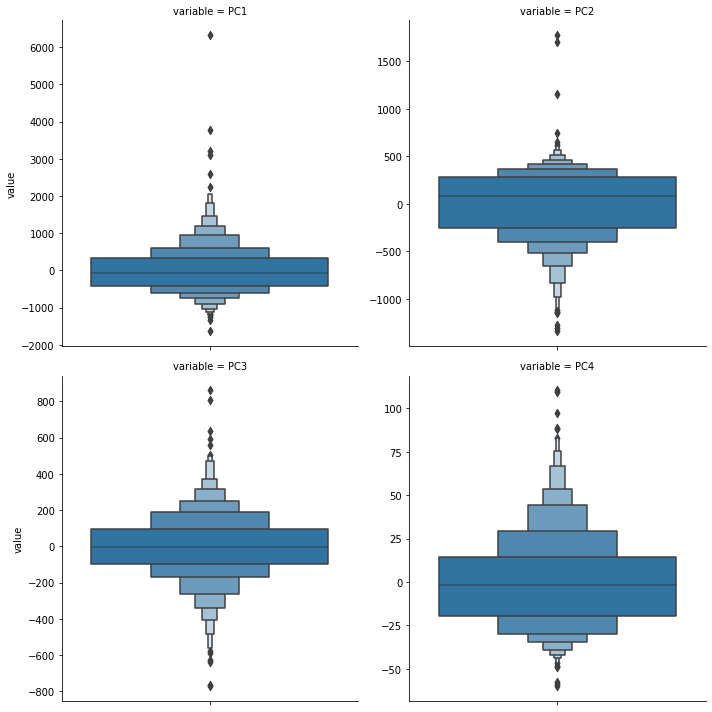

In [8]:
pca, X_pca, loadings = apply_pca(X)

sns.catplot(
    y="value",
    col="variable",
    data=X_pca.melt(),
    kind='boxen',
    sharey=False,
    col_wrap=2,
);

As you can see, there are a few data points that are separate from the distribution. To ensure that the algorithm learns only general patterns, we will remove these data points from the dataset.

In [9]:
PCs = ["PC1","PC2","PC3","PC4"]
pc_list = []
for i in PCs:
    component = i
    idx = X_pca[component].sort_values(ascending=False).index
    for i in idx[0:7]:
        if i in pc_list:
            continue
        else:
            pc_list.append(i)
pc_list

[1298,
 523,
 1182,
 691,
 496,
 1169,
 1353,
 332,
 440,
 1373,
 224,
 1044,
 1061,
 1190,
 581,
 268,
 1404,
 270,
 1438,
 747,
 304,
 583,
 185,
 676,
 716]

In [10]:
len(pc_list)

25

In [11]:
df_pca = df.loc[pc_list, ["SalePrice", "Neighborhood", "SaleCondition"] + pca_features]
df_pca.sort_values(['SaleCondition'])

,SalePrice,Neighborhood,SaleCondition,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt
Id,,,,,,,
304,149900,CollgCr,Abnorml,894,552,894,1972
496,34900,IDOTRR,Abnorml,720,0,720,1920
224,97000,NAmes,Abnorml,864,576,864,1971
1061,213500,StoneBr,Normal,1338,582,1338,2001
185,127000,BrkSide,Normal,1252,576,504,1908
583,118500,Edwards,Normal,816,0,816,1990
747,236000,Gilbert,Normal,2256,554,952,2000
270,148000,Edwards,Normal,1113,504,1143,1976
1404,282922,Somerst,Normal,1464,754,1485,2007


We will be getting rid of these data entries

In [12]:
# Before
print(df.shape)

# After
df.drop(pc_list,inplace = True)
print(df.shape)

(1460, 80)
(1435, 80)


### Columns with a lot of Missing Values

In [13]:
for i in df.columns:
    g = df[i].isnull().sum()
    if g >= 1100:
        print(i)

Alley
PoolQC
Fence
MiscFeature


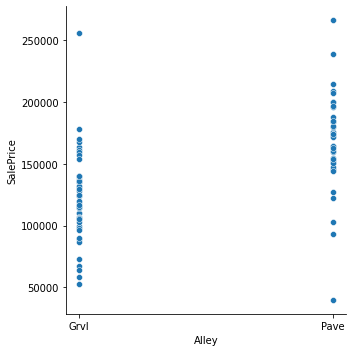

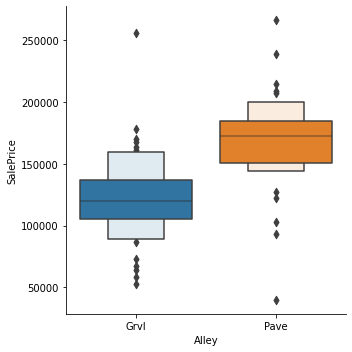

In [14]:
sns.relplot(
    x="Alley", y="SalePrice", data=df);
sns.catplot(x="Alley", y="SalePrice", data=df, kind="boxen");

Although it has a lot of missing values; there is a relationship between "Alley" and "SalesPrice": Houses with "Grvl" Alleys seem to be cheaper than those with "Pave" Alleys. We will be keeping this feature

In [15]:
c = df[df['SalePrice']> 250000] 
c[c["Alley"] == "Pave"]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
748,70,RM,65.0,11700,Pave,Pave,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,265979


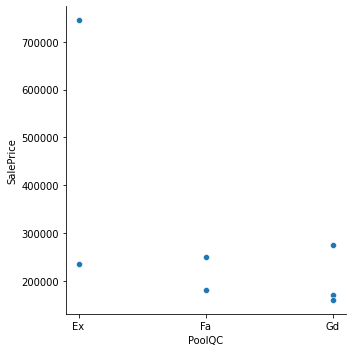

In [16]:
sns.relplot(
    x="PoolQC", y="SalePrice", data=df);

delete: PoolQC

It looks like it only has 6 samples, so we will be deleting the feature

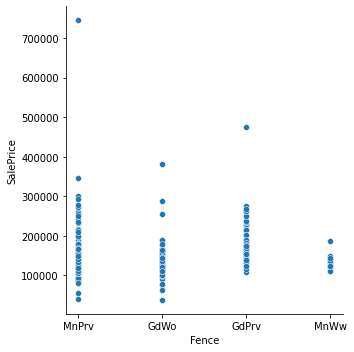

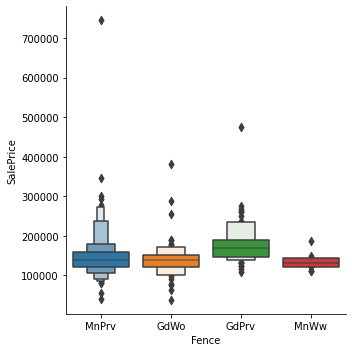

In [17]:
sns.relplot(
    x="Fence", y="SalePrice", data=df);
sns.catplot(x="Fence", y="SalePrice", data=df, kind="boxen");

Although the feature has a lot of missing values; there seems to be a relationship between the type of Fence and price but the mean SalePrice for "MnPrv", "GdWo" and "MnWw" types of Fence are very similar and so we will be deleting this feature

delete: Fence

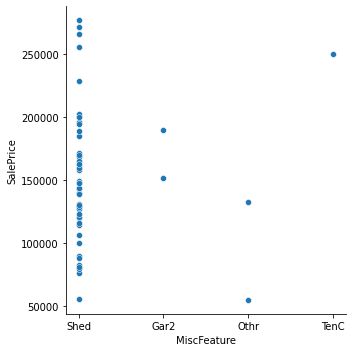

In [18]:
sns.relplot(
    x="MiscFeature", y="SalePrice", data=df);

For each category, the range is too wide. For the category "TenC", there is only 1 example, this can lead to overfitting and so we will be getting rid of the feature

delete: MiscFeature

In [19]:
#Create list based on similarities. I created my list based on common names

MS = ['MSSubClass', 'MSZoning']
Basement = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'] #Done
Bath = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'] #Done
Lot = ['LotFrontage', 'LotArea', 'LotShape', 'LotConfig']
Land = ['LandSlope', 'LandContour']
Floor = ['1stFlrSF', '2ndFlrSF']
Year = ['YearBuilt', 'YearRemodAdd', 'YrSold', 'MoSold'] # Done
Pool = ['PoolArea']
Kitchen = ['KitchenAbvGr', 'KitchenQual'] # Done
Porch = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch'] # Done
Garage = ['GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'] # Done

Ground = ['GrLivArea', 'BedroomAbvGr', 'TotRmsAbvGrd',] # Done
Overall = ['OverallQual', 'OverallCond'] # Done
Heating = ['Heating', 'HeatingQC'] # Done
Misc = ['MiscFeature', 'MiscVal']
Exterior = ['Exterior1st', 'Exterior2nd'] #Done
Engineering = ['Utilities', 'Electrical', 'CentralAir','Fireplaces', 'PavedDrive', 'WoodDeckSF', 'SaleType',
       'Neighborhood', 'BldgType', 'Street', 'Foundation', 'Functional'] # Done
Roof = ['RoofStyle',  'RoofMatl']
Style = ['RoofStyle',  'HouseStyle']
Quality = ['OverallQual', 'ExterQual', 'BsmtQual', 'HeatingQC', 'LowQualFinSF', 'KitchenQual', 'FireplaceQu', 'GarageQual'] # Done
Condition = ['Condition1', 'Condition2', 'OverallCond', 'ExterCond', 'BsmtCond', 'GarageCond', 'SaleCondition'] # Done
Mas = ['MasVnrType', 'MasVnrArea',]
Surface_Areas = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF'] # Done

feature_list = [MS, Basement, Bath, Lot, Year, Pool, Kitchen, Porch, Garage, Overall, Heating, Condition, 
                Misc, Exterior, Engineering, Style, Quality, Condition, Mas, Roof, Land, Floor, Ground, Surface_Areas]

#### BASEMENT ANALYSIS

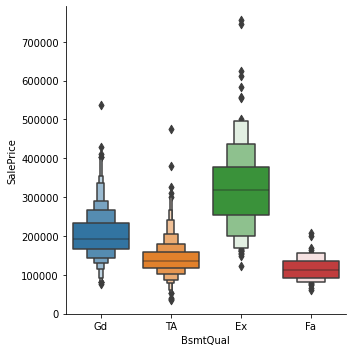

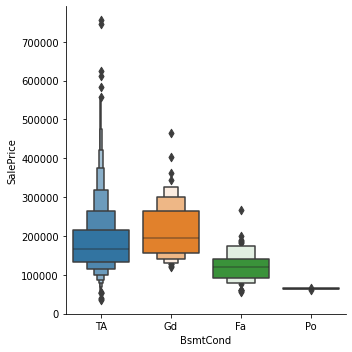

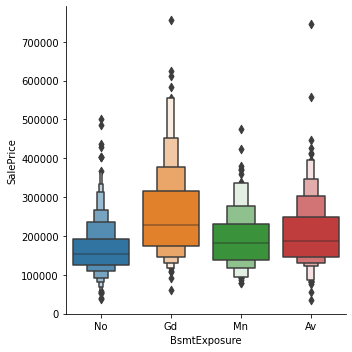

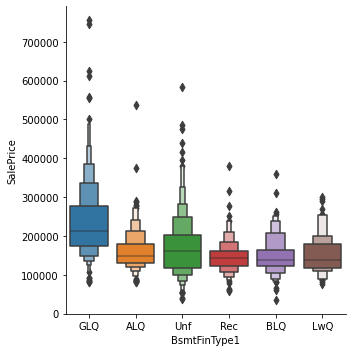

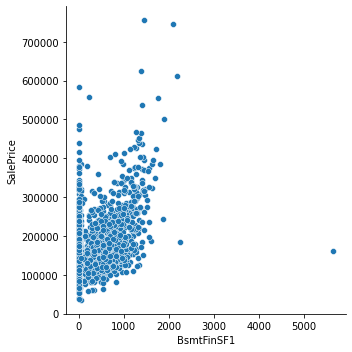

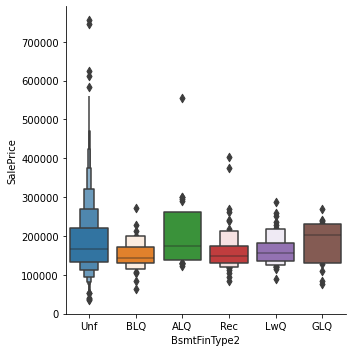

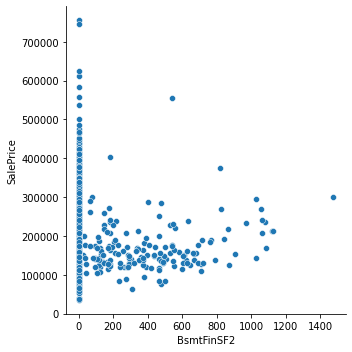

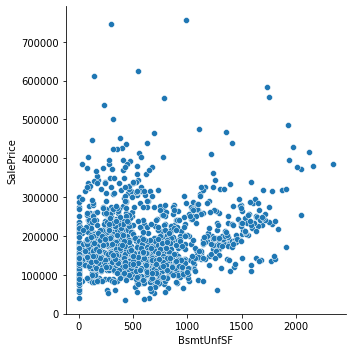

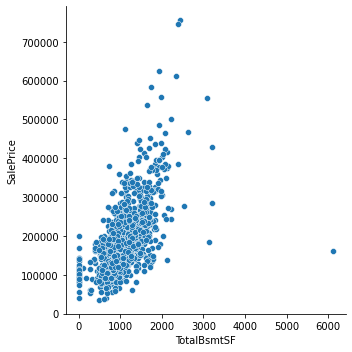

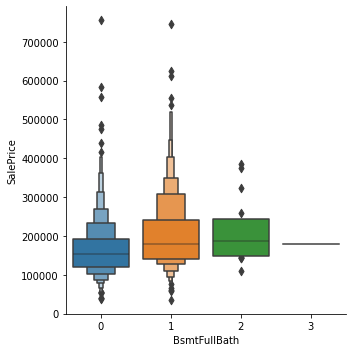

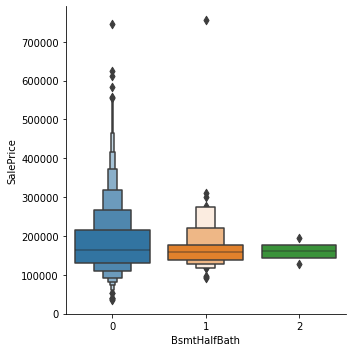

In [20]:
#Basement = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       # 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
Basement_int = ['BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF1']
for i in Basement:
    if i in Basement_int:
        sns.relplot(x=i, y="SalePrice", data=df);
    else:
        sns.catplot(x=i, y="SalePrice",data=df, kind="boxen");    

In [21]:
df[['TotalBsmtSF', "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"]]

,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF
Id,,,,
1,856,706,0,150
2,1262,978,0,284
3,920,486,0,434
4,756,216,0,540
5,1145,655,0,490
...,...,...,...,...
1456,953,0,0,953
1457,1542,790,163,589
1458,1152,275,0,877


"TotalBsmtSF" is an addition of "BsmtFinSF1", "BsmtFinSF2" and "BsmtUnfSF" and therefore will be a better determinant of "SalePrice" than each of the individual features ("BsmtFinSF1", "BsmtFinSF2" and "BsmtUnfSF"). Therefore, we will be removing the individual featuress.

Delete: "BsmtFinSF1", "BsmtFinSF2" and "BsmtUnfSF"

#### YEAR ANALYSIS

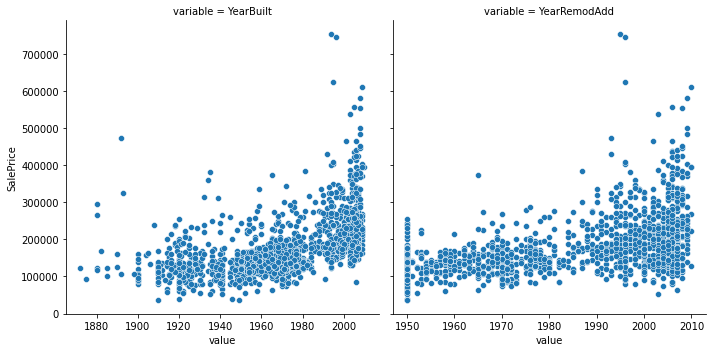

In [22]:
features = ["YearBuilt", "YearRemodAdd"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

#### From the graph, I observed that houses newly built or remodelled are more likely to have a higher "SalePrice" compared to those bought in earlier times. Especially after 1990.

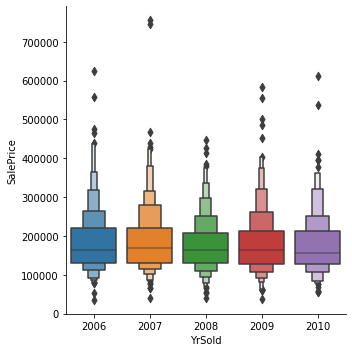

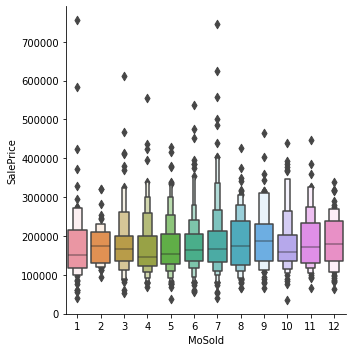

In [23]:
features = ["YrSold", "MoSold"]
sns.catplot(x="YrSold", y="SalePrice", data=df, kind="boxen");
sns.catplot(x="MoSold", y="SalePrice",data=df, kind="boxen");


#####  From the above graph, "YearSold" does not seem to be significant in determining "SalePrice", "MonthSold" on the other hand seems to show the frequency of houses but it is not a determining factor of "SalePrice"

delete: YrSold and MoSold

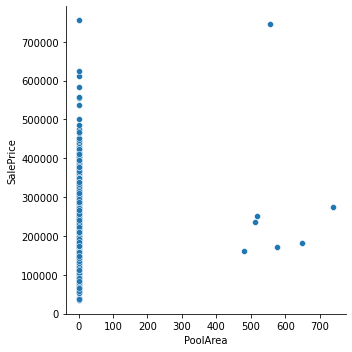

In [24]:
sns.relplot(
    x="PoolArea", y="SalePrice", data=df);

##### Pool Area doesn't seem to be a good indicator of SalePrice because it seems like a lot more houses that have "0" pool area than others

Delete PoolArea

#### KITCHEN ANALYSIS

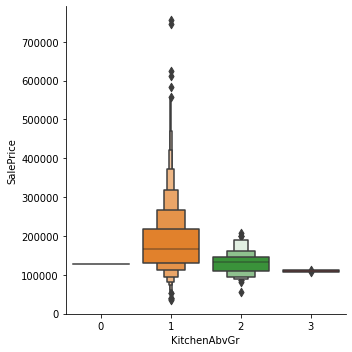

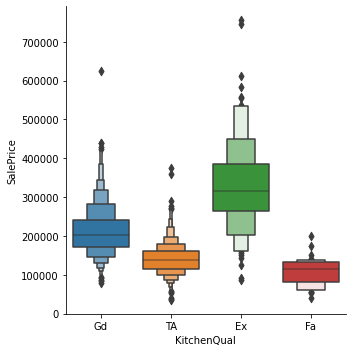

In [25]:
# CATPLOT OF THE KITCHEN FEATURES

features = ["KitchenAbvGr", "KitchenQual"]
sns.catplot(x="KitchenAbvGr", y="SalePrice", data=df, kind="boxen");
sns.catplot(x="KitchenQual", y="SalePrice",data=df, kind="boxen");

<AxesSubplot:xlabel='KitchenAbvGr', ylabel='Density'>

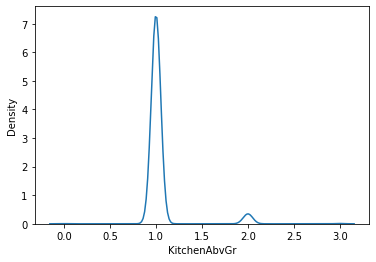

In [26]:
sns.kdeplot(df["KitchenAbvGr"]) 

##### Kitchen Quality seems to be a good indicator of SalePrice

##### Kitched Above Ground doesn't seem to be a good indicator of SalePrice because it seems like a lot more houses have "1" kitchen
##### than the other numbers (0, 2, and 3)

Delete: KitchenAbvGr

#### PORCH ANALYSIS

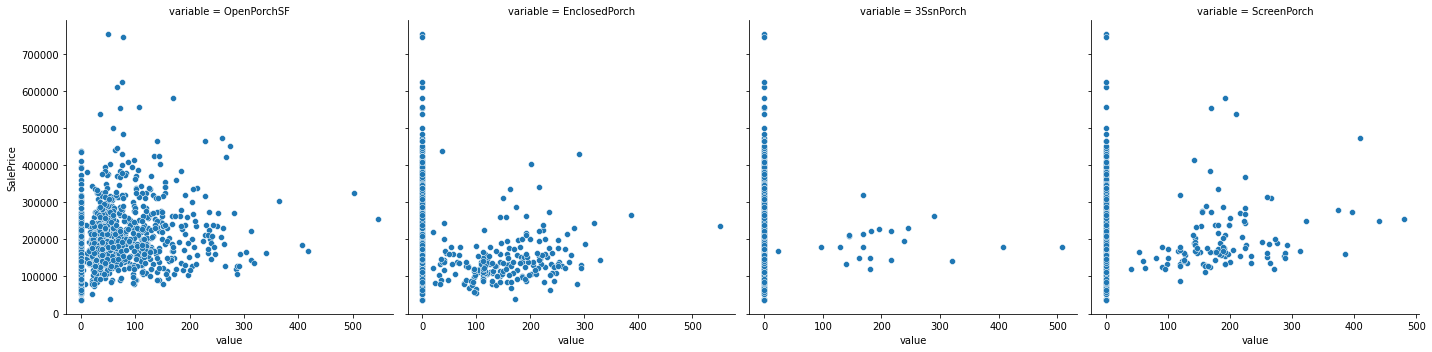

In [27]:
features = Porch 
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

In [28]:
df["TotalPorch"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["ScreenPorch"] + df["3SsnPorch"]

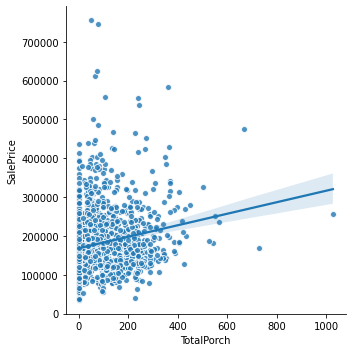

In [29]:
sns.lmplot(x="TotalPorch", y="SalePrice", data=df, scatter_kws={"edgecolor": 'w'});

The new feature "TotalPorch" looks a lot great and so I will be deleting the rest

Delete: "OpenPorchSF", "EnclosedPorch", "ScreenPorch","3SsnPorch"

#### GARAGE ANALYSIS

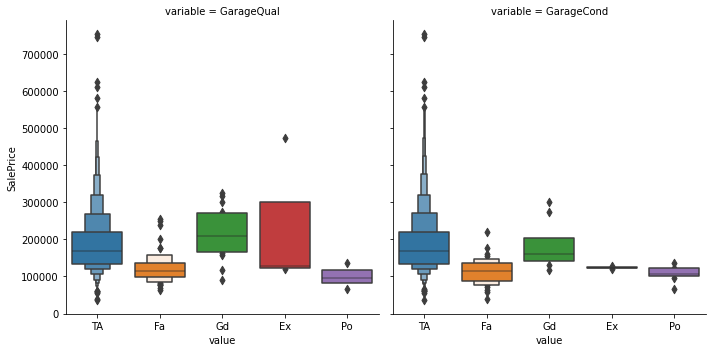

In [30]:
features = ["GarageQual", "GarageCond"]
sns.catplot(x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), 
            facet_kws=dict(sharex=False), kind = "boxen");

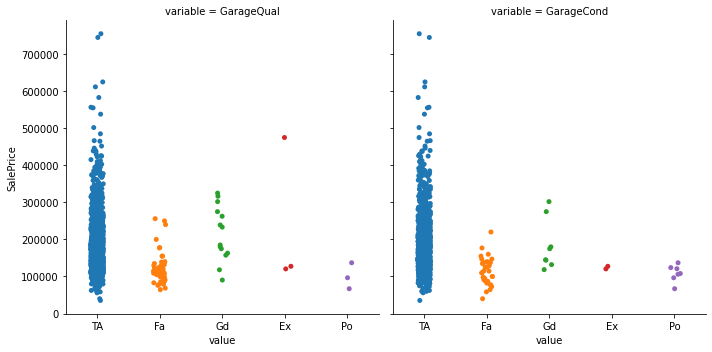

In [31]:
sns.catplot(x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), 
            facet_kws=dict(sharex=False));

##### There seems to be more houses with the category: "Ta" for both "GarageCond" and "GarageQual". "GarageCond" seems to be a better determinant of SalePrice than "GarageQual" because the data seems to be more together for category.

Delete GarageQual

#### GROUND ANALYSIS

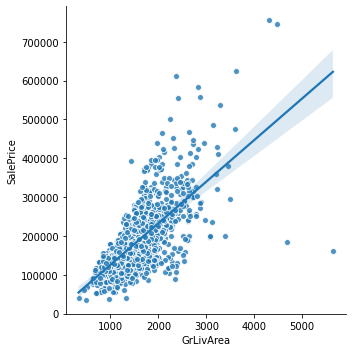

In [32]:
# Relationship between "GrLivArea" and "SalePrice"
sns.lmplot(x="GrLivArea", y="SalePrice", data=df, scatter_kws={"edgecolor": 'w'});

##### There is definitely a direct relationship between "GrLivArea" and "SalePrice"

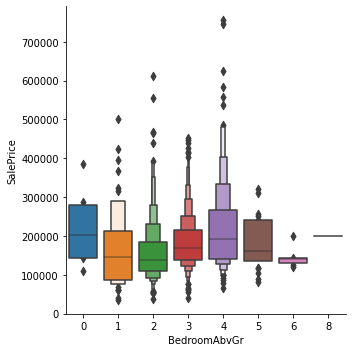

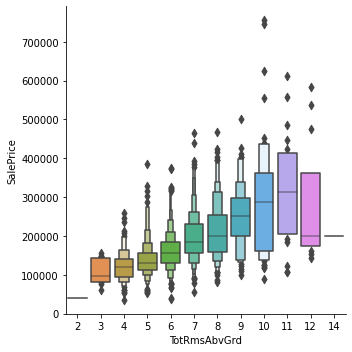

In [33]:
features = ["BedroomAbvGr", "TotRmsAbvGrd"]
sns.catplot(x="BedroomAbvGr", y="SalePrice", data=df, kind="boxen");
sns.catplot(x="TotRmsAbvGrd", y="SalePrice",data=df, kind="boxen");

##### "TotRmsAbvGrd" looks to be a better determinant of "SalePrice" than "BedroomAbvGrd"

Delete: BedroomAbvGrd

#### OVERALL ANALYSIS

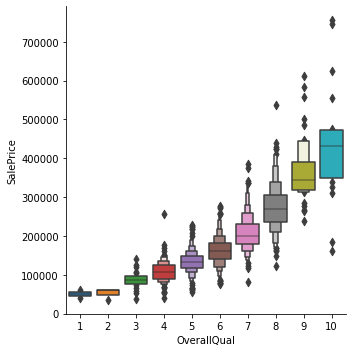

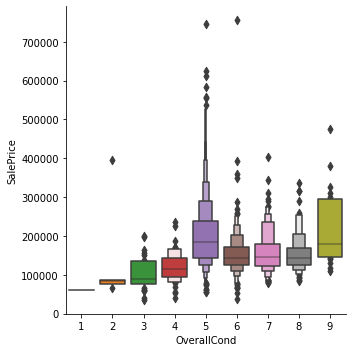

In [34]:
features = ["OverallQual", "OverallCond"]
sns.catplot(x="OverallQual", y="SalePrice", data=df, kind="boxen");
sns.catplot(x="OverallCond", y="SalePrice",data=df, kind="boxen");

##### "OverallQual" is DEFINITELY a better determinant of "SalePrice" than "OverallCond"

Delete: OverallCond

#### HEATING ANALYSIS

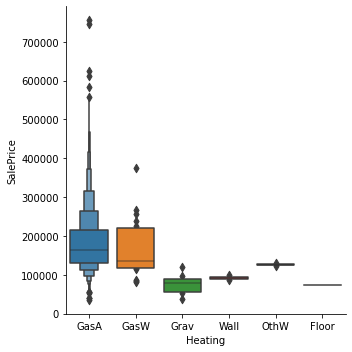

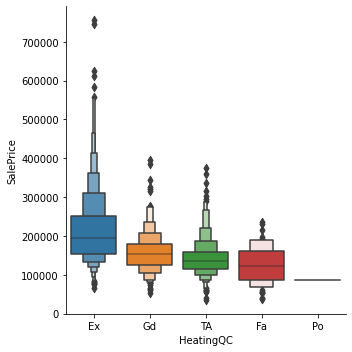

In [35]:
features = ["Heating", "HeatingQC"]
sns.catplot(x="Heating", y="SalePrice", data=df, kind="boxen");
sns.catplot(x="HeatingQC", y="SalePrice",data=df, kind="boxen");

##### "HeatingQC" looks to be a better determinant of "SalePrice" than "Heating"

Delete: Heating

#### GARAGE ANALYSIS

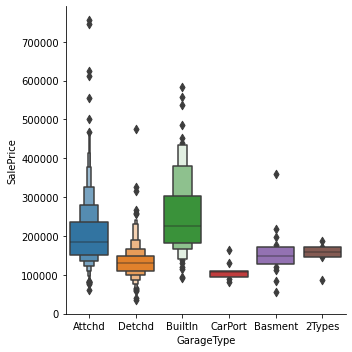

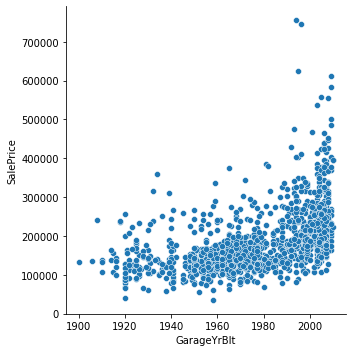

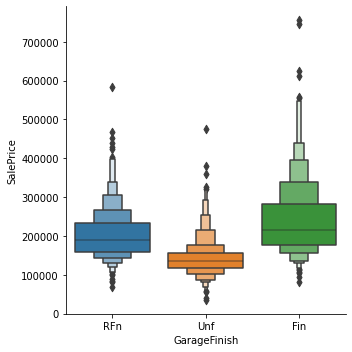

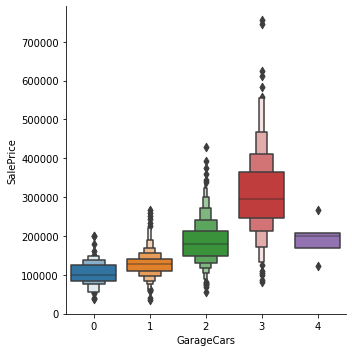

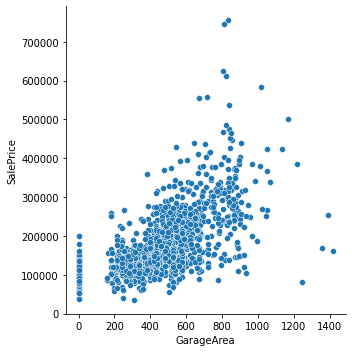

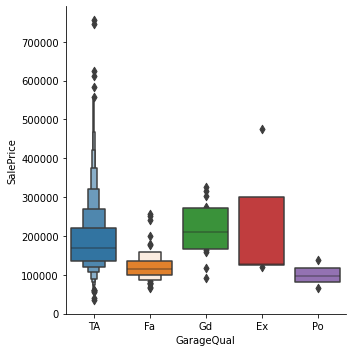

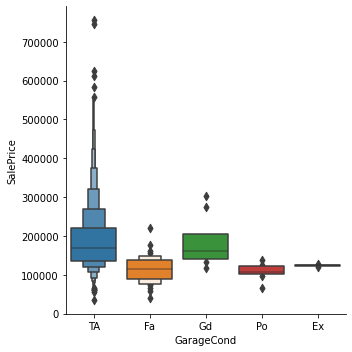

In [36]:
# Garage = ['GarageType', 'GarageYrBlt','GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']
Garage_int = ["GarageYrBlt","GarageArea"]
for i in Garage:
    if i in Garage_int:
        sns.relplot(x=i, y="SalePrice", data=df);
    else:
        sns.catplot(x=i, y="SalePrice",data=df, kind="boxen");

They all have a relationship to Price. We will keep them all.

#### BATH ANALYSIS

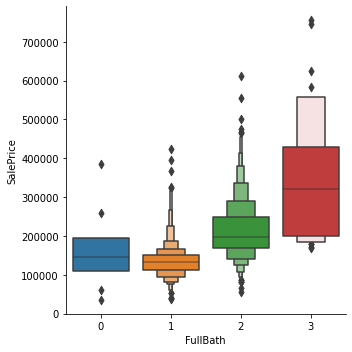

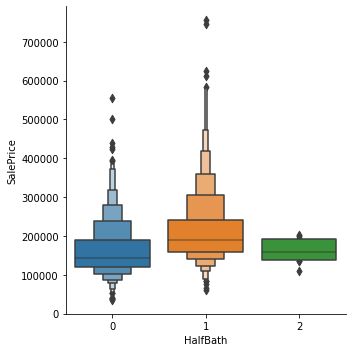

In [37]:
# Bath = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']
Bath_rl = ['FullBath', 'HalfBath']
for i in Bath_rl:
    sns.catplot(x=i, y="SalePrice",data=df, kind="boxen");   

There is a relationship between the features and SalesPrice.

#### EXTERIOR ANALYSIS

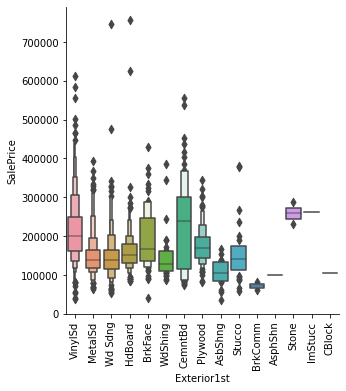

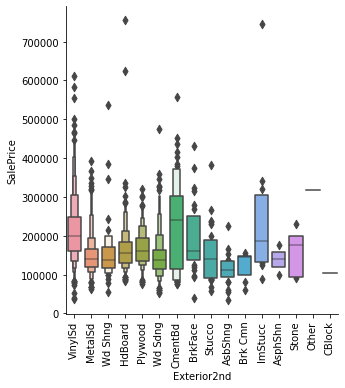

In [38]:
#Exterior = ['Exterior1st', 'Exterior2nd']
for i in Exterior:
    sns.catplot(x=i, y="SalePrice",data=df, kind="boxen");
    plt.xticks(rotation= 'vertical')

   There are too many categories and quite large ranges. We will be deleting this features. 
   You can also do this or pick 1 of them. If I were to pick, I'd pick "Exterior 2nd"

Delete: Exterior1st and Exterior2nd

#### ENGINEERING ANALYSIS

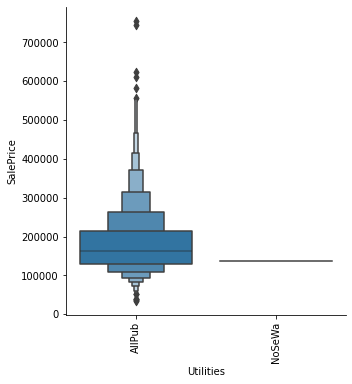

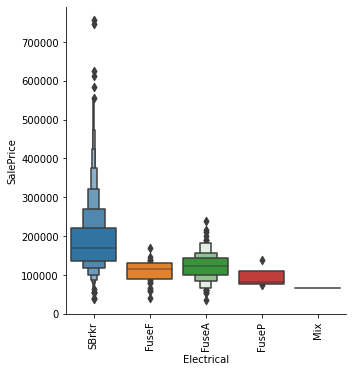

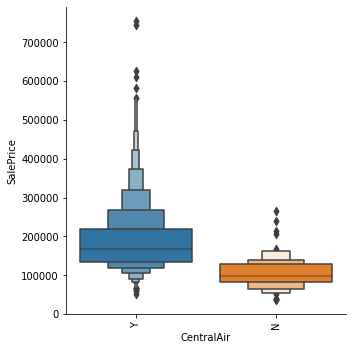

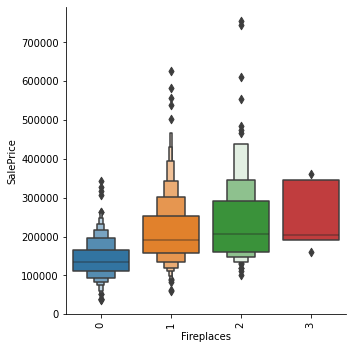

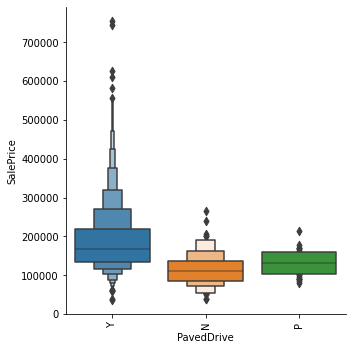

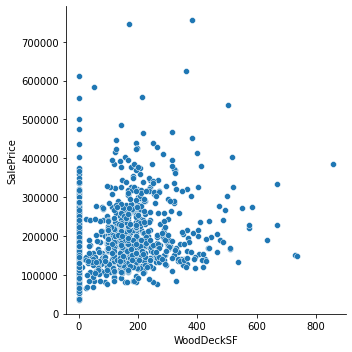

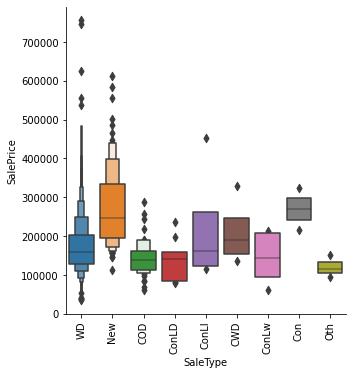

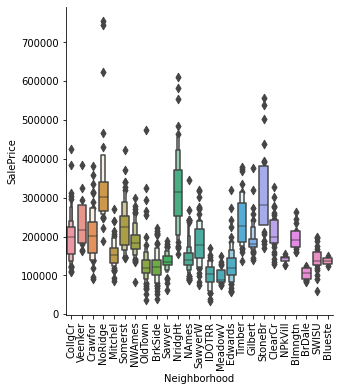

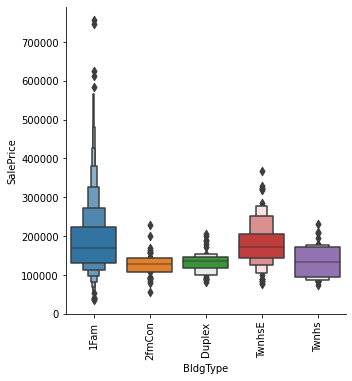

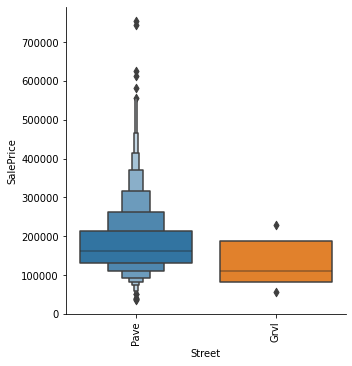

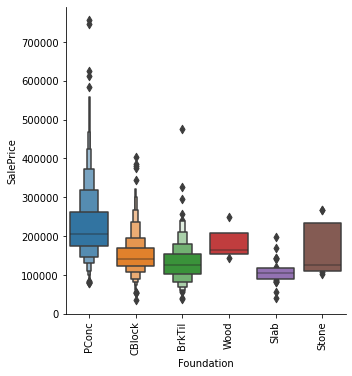

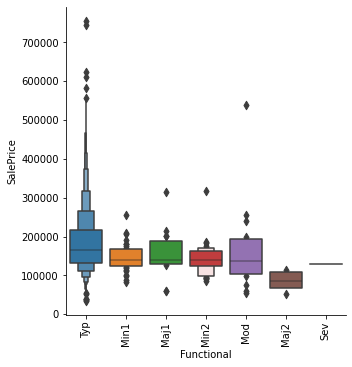

In [39]:
# Engineering = ['Utilities', 'Electrical', 'CentralAir','Fireplaces', 'PavedDrive', 'WoodDeckSF', 'SaleType',
       #'Neighborhood', 'BldgType', 'Street', 'Foundation', 'Functional']
for i in Engineering:
    if i == "WoodDeckSF":
        sns.relplot(x=i, y="SalePrice", data=df);
    else:
        sns.catplot(x=i, y="SalePrice",data=df, kind="boxen"); 
        plt.xticks(rotation= 'vertical')
        
        

All the features seem okay except: "Utilities" and "Functional". 
"Utilities" has skewed data
"Function", the categories have similar ranges and means
We will be deleting them

Delete: Utilities, Functional

#### QUALITY ANALYSIS

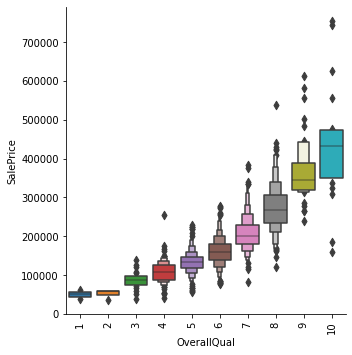

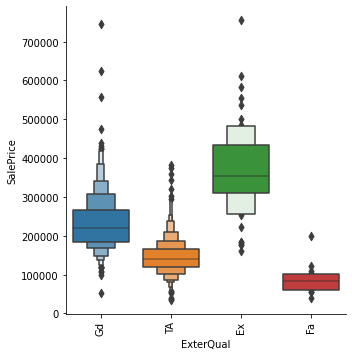

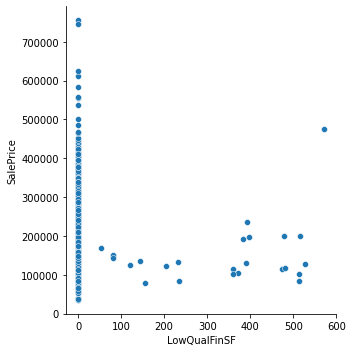

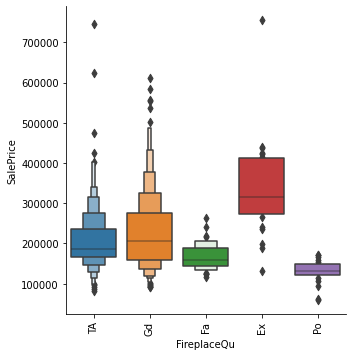

In [40]:
# Quality = ['OverallQual', 'ExterQual', 'BsmtQual', 'HeatingQC', 'LowQualFinSF', 'KitchenQual', 'FireplaceQu', 'GarageQual'] 
Quality_rl = ["OverallQual", "ExterQual", "LowQualFinSF", "FireplaceQu"]

for i in Quality_rl:
    if i == "LowQualFinSF":
        sns.relplot(x=i, y="SalePrice", data=df);
    else:
        sns.catplot(x=i, y="SalePrice",data=df, kind="boxen");
        plt.xticks(rotation= 'vertical')

All the features look good: ESPECIALLY "OverallQual"
Although "LowQualFinSF" isn't a good determinant of "SalePrice". We are removing it.

Delete LowQualFinSF

#### CONDITION ANALYSIS

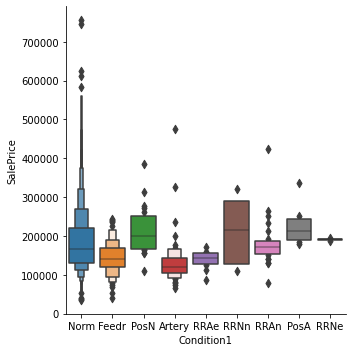

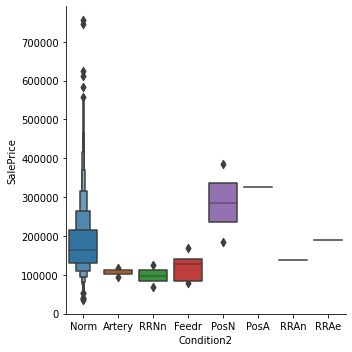

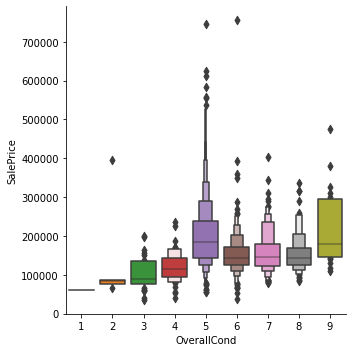

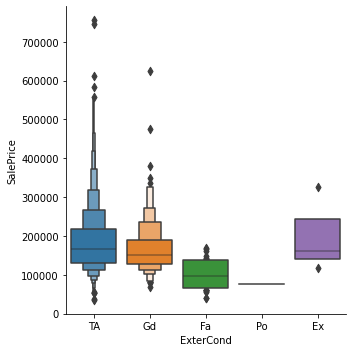

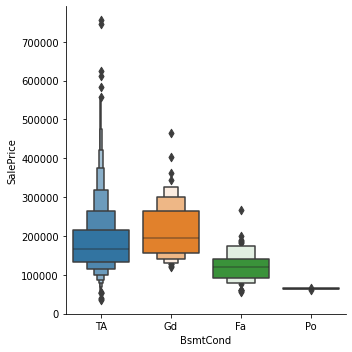

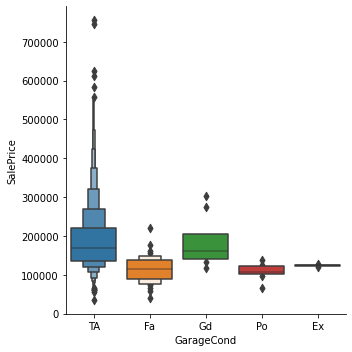

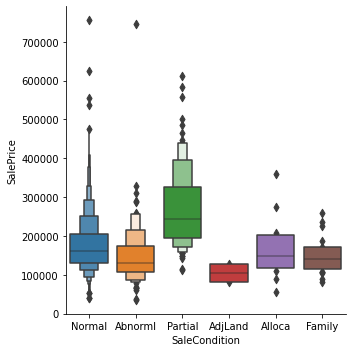

In [41]:
for i in Condition:
    sns.catplot(x=i, y="SalePrice", data=df, kind="boxen");

From the graph, it looks like there isn't the expected pattern that you'd expected with a feature like this. What I mean is, normally as the Condition increases, the price should increase but all the features have varying distributions.

Delete Condition2

#### SURFACE AREAS ANALYSIS

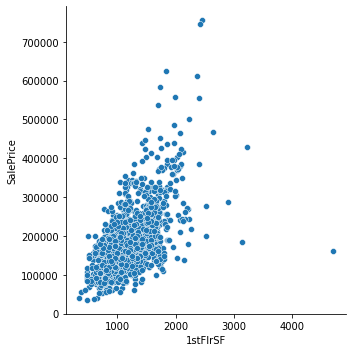

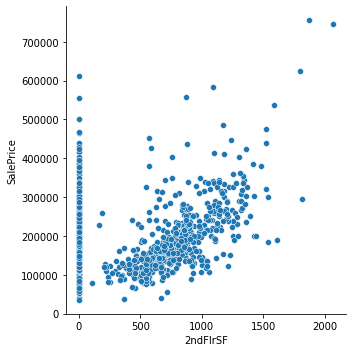

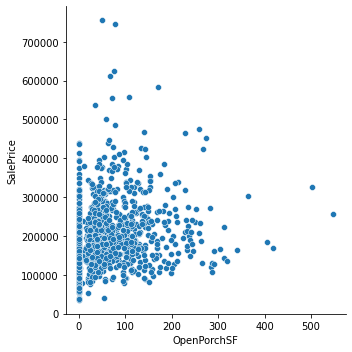

In [42]:
# Surface_Areas = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'OpenPorchSF', 'WoodDeckSF']
Surface_Areas_rl = ["1stFlrSF", "2ndFlrSF", "OpenPorchSF"]

for i in Surface_Areas_rl:
    sns.relplot(x=i, y="SalePrice", data=df);

They all look good BUT DO YOU KNOW WHAT MIGHT LOOK BETTER?
A new feature which is an addition of all the features

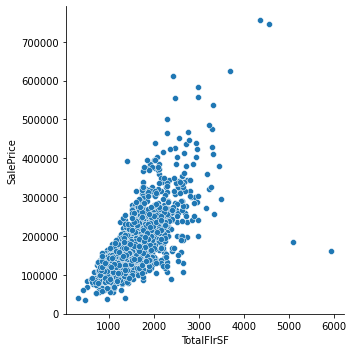

In [43]:
df["TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] + df["OpenPorchSF"]
sns.relplot(x= "TotalFlrSF", y="SalePrice", data=df);

NOW that looks so much better. We can go ahead and delete the individual features: ["1stFlrSF", "2ndFlrSF", "OpenPorchSF"]

Delete: "1stFlrSF", "2ndFlrSF", "OpenPorchSF"

In [44]:
Remove_Features = ["PoolQC","Fence","MiscFeature","YrSold","MoSold", "PoolArea","KitchenAbvGr","OpenPorchSF","EnclosedPorch","ScreenPorch","3SsnPorch",
                   "GarageCond", "BedroomAbvGr","OverallCond","Heating","BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",'Exterior1st', 'Exterior2nd', 
                   "Utilities", "Functional", "LowQualFinSF","Condition2","1stFlrSF", "2ndFlrSF"]


def remove_feature(df_copy, Remove_Features):
    d = []
    for i in df_copy.columns:
        d.append(i)
    for i in Remove_Features:
        d.remove(i)
    df_copy = df_copy[d]
    return df_copy

### Remove Data Points

Two data points seem to be sticking out and they look like they both have a "SalePrice" about 700,000

In [45]:
ind = df[df["SalePrice"] > 700000].index
df.drop(ind, inplace=True)

In [46]:
df[df["SalePrice"] > 700000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalPorch,TotalFlrSF
Id,,,,,,,,,,,,,,,,,,,,,


We have successfully, deleted the data points

#### DEFINE CATEGORICAL FEATURES
Category Features are not yet considered as categorical and so we need to do that ourselves

In [47]:
# Based on your data analysis, create a list of features that contain categorical data
Category = []
for i in df.select_dtypes("object"):
    if i in Remove_Features:
        continue
    else:
        Category.append(i)

In [48]:
# Based on your data analysis, create a list of features that contain categorical data
#Category = ['MSZoning',  'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
             #'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond',
             #'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
             #'CentralAir', 'Electrical', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
             #'PavedDrive', 'SaleType', 'SaleCondition']

five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
six_levels = ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
ten_levels = list(range(10))

ordered_levels = {
   "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df_copy):
    # Nominal categories
    for name in Category:
        df_copy[name] = df_copy[name].astype("category")
        # Add a None category for missing values
        if "None" not in df_copy[name].cat.categories:
            df_copy[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df_copy[name] = df_copy[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    for i in df_copy.select_dtypes("category").columns:
        string = df_copy[i].unique()
        number = list(range(len(string)))
        df_copy[i].replace(string, number, inplace = True)
    return df_copy

#### HANDLE MISSING VALUES

In [49]:
def replace_miss(df_copy):
    for name in df_copy.select_dtypes("number"):
        mean = round((df_copy[name].mean(axis = 0, skipna=True)), 2)
        df_copy[name] = df_copy[name].fillna(mean)
    for name in df_copy.select_dtypes("category"):
        df_copy[name] = df_copy[name].fillna("None")
    return df_copy

In [50]:
df_copy = df.copy()
df_copy = encode(df_copy)
df_copy = remove_feature(df_copy, Remove_Features)
df_copy = replace_miss(df_copy)
df_copy.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,GarageArea,GarageQual,PavedDrive,WoodDeckSF,MiscVal,SaleType,SaleCondition,SalePrice,TotalPorch,TotalFlrSF
Id,,,,,,,,,,,,,,,,,,,,,
1,60,0,65.0,8450,0,0,0,0,0,0,...,548,0,0,0,0,0,0,208500,61,1771
2,20,0,80.0,9600,0,0,0,0,1,0,...,460,0,0,298,0,0,0,181500,0,1262
3,60,0,68.0,11250,0,0,1,0,0,0,...,608,0,0,0,0,0,0,223500,42,1828
4,70,0,60.0,9550,0,0,1,0,2,0,...,642,0,0,0,0,0,1,140000,307,1752
5,60,0,84.0,14260,0,0,1,0,1,0,...,836,0,0,192,0,0,0,250000,84,2282


In [51]:
y = df_copy[["SalePrice"]]
df_copy.drop("SalePrice", axis=1, inplace = True)
X = df_copy

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 234)

c = []
for name in X_train.select_dtypes("number"):
    if X_train[name].nunique() > 40:
        c.append(name)
scaler = StandardScaler()
X_train[c] = scaler.fit_transform(X_train[c])
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,GarageCars,GarageArea,GarageQual,PavedDrive,WoodDeckSF,MiscVal,SaleType,SaleCondition,TotalPorch,TotalFlrSF
Id,,,,,,,,,,,,,,,,,,,,,
497,20,0,0.004228,0.192559,0,0,1,0,0,0,...,2,0.319047,0,0,1.367184,0,0,0,2.760082,3.164810
510,20,0,0.474086,-0.105690,0,0,0,0,2,0,...,1,-0.945446,0,0,1.044660,0,0,0,0.004674,-0.782630
1005,120,0,-1.266129,-0.724758,0,0,0,0,0,0,...,2,-0.088707,0,0,0.496368,0,0,0,-0.867541,-0.101724
15,20,0,0.004228,0.021635,0,0,1,0,2,0,...,1,-0.569764,0,0,-0.761478,0,0,0,2.988047,-0.170722
1223,50,0,0.380021,-0.019263,0,0,0,0,0,0,...,1,-0.739279,0,0,-0.761478,0,0,0,-0.867541,0.519263


Feature: 0, Score: 0.000359
Feature: 1, Score: 0.001178
Feature: 2, Score: 0.001940
Feature: 3, Score: 0.001680
Feature: 4, Score: 0.005674
Feature: 5, Score: 0.000563
Feature: 6, Score: 0.000495
Feature: 7, Score: 0.001184
Feature: 8, Score: 0.000364
Feature: 9, Score: 0.004138
Feature: 10, Score: 0.001832
Feature: 11, Score: 0.002156
Feature: 12, Score: 0.001148
Feature: 13, Score: 0.000475
Feature: 14, Score: 0.018987
Feature: 15, Score: 0.025539
Feature: 16, Score: 0.019747
Feature: 17, Score: 0.001414
Feature: 18, Score: 0.000122
Feature: 19, Score: 0.001532
Feature: 20, Score: 0.002187
Feature: 21, Score: 0.044129
Feature: 22, Score: 0.000598
Feature: 23, Score: 0.000108
Feature: 24, Score: 0.010467
Feature: 25, Score: 0.001022
Feature: 26, Score: 0.001313
Feature: 27, Score: 0.007310
Feature: 28, Score: 0.000772
Feature: 29, Score: 0.020304
Feature: 30, Score: 0.000972
Feature: 31, Score: 0.001566
Feature: 32, Score: 0.000425
Feature: 33, Score: 0.007202
Feature: 34, Score: 0.00

<BarContainer object of 55 artists>

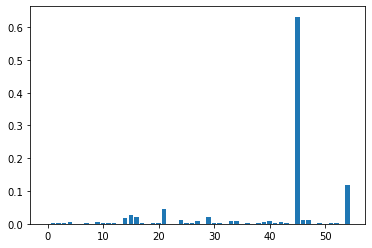

In [53]:
model= XGBRegressor()

model.fit(X_train, y_train)

importance = model.feature_importances_ 
for i,v in enumerate(importance):
  print("Feature: %d, Score: %5f" %(i,v))
plt.bar([x for x in range(len(importance))], importance)

In [54]:
# Create a list of tuples that contain the sorted version of the feature importance, from the lowest score to the highest
importance_dict = dict()
for i,v in enumerate(importance):
    importance_dict[i] = v
importance_dict
new_dict = sorted(importance_dict.items(), key=lambda x:x[-1])

In [55]:
# A list containing the numbers of the features acording to lowest to highest score
feat_list = []
for i in new_dict:
    feat_list.append(i[0])

In [56]:
# Create a dictionary of all the columns with the keys as its index number
feat_dict = dict()
for i,v in enumerate(df_copy.columns):
    feat_dict[i] = v

# Create a dictionary that includes the rearranged columns according to lowest to highest score
new_feat_dict = dict()
for i in feat_list:
    new_feat_dict[i] = feat_dict[i]

In [57]:
# Predict our Test set
X_test[c] = scaler.transform(X_test[c])
pred = model.predict(X_test)

score = r2_score(y_test, pred)

print("r2 Score: %.2f" %(score))

r2 Score: 0.85


The squared error is 0.85, which is very good

In [58]:
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col = 'Id')

In [59]:
df_test["TotalPorch"] = df_test["OpenPorchSF"] + df_test["EnclosedPorch"] + df_test["ScreenPorch"] + df_test["3SsnPorch"]
df_test["TotalFlrSF"] = df_test["1stFlrSF"] + df_test["2ndFlrSF"] + df_test["OpenPorchSF"]

In [60]:
df_test = encode(df_test)
df_test = remove_feature(df_test, Remove_Features)
df_test = replace_miss(df_test)
df_test[c] = scaler.transform(df_test[c])
df_test.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,GarageCars,GarageArea,GarageQual,PavedDrive,WoodDeckSF,MiscVal,SaleType,SaleCondition,TotalPorch,TotalFlrSF
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,0,0.474086,0.089349,0,0,0,0,0,0,...,1.0,1.162042,0,0,0.367358,0,0,0,0.321843,-1.205699
1462,20,1,0.521119,0.344480,0,0,1,0,1,0,...,1.0,-0.753024,0,0,2.407326,12500,0,0,-0.510726,-0.354113
1463,60,1,0.191889,0.302328,0,0,1,0,0,0,...,2.0,0.025831,0,0,0.947902,0,0,0,-0.530549,0.186981
1464,60,1,0.380021,-0.069229,0,0,1,0,0,0,...,2.0,-0.029147,0,0,2.141243,0,0,0,-0.510726,0.145218
1465,120,1,-1.266129,-0.548915,0,0,1,1,0,0,...,2.0,0.135787,0,0,-0.761478,0,0,0,1.372466,-0.359560


In [61]:
predictions = model.predict(df_test)

output = pd.DataFrame({'Id': df_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
